# PyTorch MNIST 99.7점 만들기

In [4]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('현재 가상환경 GPU 사용 가능상태')
else:
    device = 'cpu'
    print('GPU 사용 불가능 상태')

현재 가상환경 GPU 사용 가능상태


## MNIST 데이터 다운로드 & 전처리

In [34]:
# 하이퍼 파라미터 설정
batch_size = 128

# Image Net 추천 평균 & 표준편차
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Normalize

mnist_transform = transforms.Compose([ToTensor(),
                                     Normalize(mean=(0.5,), std=(0.5, ))])

from torchvision import datasets
train_data = datasets.MNIST(root = './', train = True, download = True, transform = mnist_transform)

from torch.utils.data import random_split
train_data, valid_data = random_split(train_data, [54000, 6000])
test_data = datasets.MNIST(root = './', train = False, download = True, transform = mnist_transform)

# # Train / Validation / Test 셋에 대한 데이터 로더 만들기
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

## 모델 선언

In [35]:
# import torch.nn as nn
# class CNN_model(nn.Module):
#     def __init__(self):
#         super(CNN_model, self).__init__()
        
#         # 1번 레이어 생성
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), # padding으로 인해 사이즈 보존
#             nn.BatchNorm2d(32), #Batch Normalization을 수행
#             nn.ReLU(), # ReLU함수에 통과시킨다.
#             nn.Dropout(0.5), # Drop Out 수행            
#             nn.MaxPool2d(kernel_size = 2, stride = 2), # 커널 사이즈 2, stride 2로 통과시킴으로서 사진 크기가 1/2로 줄어듬
#         )
        
#         # 2번 레이어 생성
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
        
#         # 3번 레이어 생성
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
        
#         #마지막 0 ~ 9 classification을 위한 fully connected layer 생성
#         self.fc1 = nn.Linear(3* 3 * 128, 10, bias = True) # 2번의 맥스풀링을 거쳐서 28 -> 14 -> 7이 되었고 채널이 64개
        
#         #가중치 초기화
#         nn.init.xavier_uniform_(self.fc1.weight)

#    #모델 설계 후 데이터셋이 layer들을 통과할 수 있게 함.
#     def forward(self, x):
#         conv_out = self.layer1(x)
#         out = self.layer2(conv_out)
#         out = self.layer3(out)
#         out = out.view(out.size(0), -1) # 3차원 -> 1차원 Flatten
#         out = self.fc1(out)
#         return out, conv_out

# # Model structure check
# from torchsummary import summary as Summary
# Summary(CNN_model().to(device),(1, 28, 28))

In [66]:
maximum_epoch = 30
# learning_rate = 0.0072
learning_rate = 0.01

import torch.nn as nn
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        
        # 1번 레이어 생성
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), # padding으로 인해 사이즈 보존
            nn.BatchNorm2d(32), #Batch Normalization을 수행
            nn.ReLU(), # ReLU함수에 통과시킨다.
            nn.Dropout(0.4), # Drop Out 수행            
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 커널 사이즈 2, stride 2로 통과시킴으로서 사진 크기가 1/2로 줄어듬
        )
        
        # 2번 레이어 생성
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
#             nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        #마지막 0 ~ 9 classification을 위한 fully connected layer 생성
        self.fc1 = nn.Linear(7 * 7 * 64, 10, bias = True) # 2번의 맥스풀링을 거쳐서 28 -> 14 -> 7이 되었고 채널이 64개
        
        #가중치 초기화
        nn.init.xavier_uniform_(self.fc1.weight)

   #모델 설계 후 데이터셋이 layer들을 통과할 수 있게 함.
    def forward(self, x):
        conv_out = self.layer1(x)
        out = self.layer2(conv_out)
        out = out.view(out.size(0), -1) # 3차원 -> 1차원 Flatten
        out = self.fc1(out)
        return out, conv_out

# Model structure check
from torchsummary import summary as Summary
Summary(CNN_model().to(device),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
           Dropout-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          18,496
       BatchNorm2d-7           [-1, 64, 14, 14]             128
              ReLU-8           [-1, 64, 14, 14]               0
         MaxPool2d-9             [-1, 64, 7, 7]               0
           Linear-10                   [-1, 10]          31,370
Total params: 50,378
Trainable params: 50,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.12
Params size (MB): 0.19
Estimated Tot

## 학습에 사용되는 함수
 - 초기화
 - 모델 구동
 - 학습 추이

#### 초기화

In [51]:
# 모델 초기화
from torch.optim import Adam
import matplotlib.pyplot as plt

def init_model():
    plt.rc('font', size = 10)
    global net, loss_fn, optim
    net = CNN_model().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)
    
    
# epoch 카운터 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0
    
def init_log():
    plt.rc('font', size = 10)
    # 모든 Log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

#### 모델 구동

In [52]:
import gc
from torch.cuda import memory_allocated, empty_cache
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()
    
# 학습 알고리즘
import numpy as np
def epoch(data_loader, mode = 'train'):
    global epoch_cnt
    
    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed, last_out, last_label = [], [], False, None, None
    
    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)

        # 1. Feed-forward
        if mode == 'train':
            net.train()
        else:
            net.eval()

        result, _ = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출
        
        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록
        
        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기르 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문 나가면 epoch 카운터 += 1
            
        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TN)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록
            
        # 5. 컨퓨전 매트릭스 출력을 위해 기록
        last_out = out.cpu().detach() # 모든 Predict 기록
        last_label = _label # 모든 GT 기록
        
    # 역전파 학습 후 Epoch 카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1
    
    clear_memory()
    
    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc), last_out, last_label

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

#### 학습 추이

In [53]:
def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
    
def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

from IPython.display import clear_output
def print_log():
    # 학습 추이 출력
    
    # 소숫점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)
    
    log_str = 'Epoch: {:3} | T_Loss {:5} | T_acc {:5} | V_Loss {:5} | V_acc. {:5} | \
🕒 {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)
    
    log_stack.append(log_str) # 프린트 준비
    
    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정
    
    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')
    
    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')
    
    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line # 위에서 선언한 plt정보들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid() # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()
    
    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))): # 반대로 sort 시켜서 출력
        print(log_stack[idx])

In [54]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience = 10, verbose = False, delta = 0, path = 'checkpoint.pth', save = False):
#         patience (int): validation loss가 개선된 후 기다리는 기간
#         verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
#         delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
#         path (str): checkpoint저장 경로

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.save = save

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        # validation loss가 감소하면 모델을 저장한다.
        if self.verbose:
            print('Validation loss decresed ({:5} --> {:5}). Saving Model...'.format(self.val_loss_min, val_loss))
        if self.save == True:
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## 모델 학습

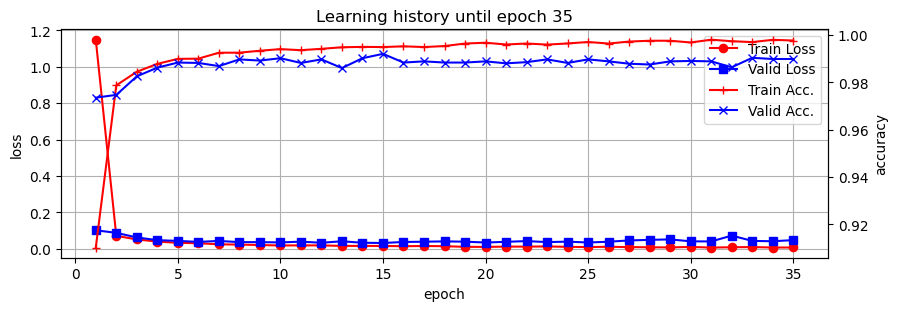

Epoch:  35 | T_Loss 0.007 | T_acc 0.998 | V_Loss 0.047 | V_acc.  0.99 | 🕒 9.036
Epoch:  34 | T_Loss 0.007 | T_acc 0.998 | V_Loss 0.041 | V_acc.  0.99 | 🕒 9.167
Epoch:  33 | T_Loss 0.009 | T_acc 0.997 | V_Loss 0.043 | V_acc.  0.99 | 🕒 9.098
Epoch:  32 | T_Loss 0.008 | T_acc 0.997 | V_Loss 0.072 | V_acc. 0.986 | 🕒 9.053
Epoch:  31 | T_Loss 0.006 | T_acc 0.998 | V_Loss  0.04 | V_acc. 0.989 | 🕒 9.204
Epoch:  30 | T_Loss  0.01 | T_acc 0.997 | V_Loss 0.041 | V_acc. 0.989 | 🕒 9.126
Epoch:  29 | T_Loss 0.007 | T_acc 0.998 | V_Loss 0.051 | V_acc. 0.989 | 🕒   9.4
Epoch:  28 | T_Loss 0.008 | T_acc 0.998 | V_Loss 0.049 | V_acc. 0.988 | 🕒 9.532
Epoch:  27 | T_Loss 0.009 | T_acc 0.997 | V_Loss 0.046 | V_acc. 0.988 | 🕒 9.071
Epoch:  26 | T_Loss 0.011 | T_acc 0.996 | V_Loss 0.038 | V_acc. 0.989 | 🕒 9.118
Epoch:  25 | T_Loss 0.009 | T_acc 0.997 | V_Loss 0.034 | V_acc.  0.99 | 🕒 9.195
Epoch:  24 | T_Loss  0.01 | T_acc 0.996 | V_Loss 0.039 | V_acc. 0.988 | 🕒 9.116
Epoch:  23 | T_Loss 0.013 | T_acc 0.996 

In [58]:
# Training Initialization
init_model()
init_epoch()
init_log()
early_stopping = EarlyStopping(patience = 20)

import time
best_test_acc, best_epoch = 0, 0
# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc, _, _ = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc, _, _ = epoch(valid_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()
    
    # early_stopping는 validation loss가 감소하였는지 확인
    early_stopping(vloss, net)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    with torch.no_grad():
        net.eval()
        _, test_acc, _, _ = epoch(test_loader, mode = 'test')
        
        # Test 점수가 가장 좋았던 모델을 저장한다
        if best_test_acc < test_acc:
            best_test_acc = test_acc
            best_epoch = epoch_cnt
            print('Epoch: {} / Test Acc: {} | 최고 점수가 갱신되었습니다. 모델 중간 저장을 시행합니다.'.format(best_epoch, round(best_test_acc, 5)))
            torch.save(net.state_dict(), './model.pth')

print('\n Training completed!')

# 정확도 검증
with torch.no_grad():
    test_loss, test_acc, _, _ = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))
    
print('저장된 Best Model: Epoch: {}/ Test Accuracy: {}'.format(best_epoch, round(best_test_acc, 3)))

In [48]:
# 계층 2개 0.99 (0.01) 0.9933(0.0072) 0.994(0.0073) 0.993(0.00734/128/70) 0.9912(inout 절반으로/0.0073/256/50)
# 계층 3개 0.992(256/50/0.005) 9914(16,32,64)


# 128/20/0.007 99.3
# 128/50/0.0073 99.1
# 992 / 9919

## 모델 정확도

In [57]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc, _, _ = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc.: 0.989
Test Loss: 0.0494


In [ ]:
# 98.6 -> 98.97 -> 98.99

## 파라미터 변경 없음
## 모델선언 1 : 97.61 // 98.26
## 모델선언 2 : 98.78 // 99.04 // 98.93

In [ ]:
net = CNN_model().to(device)
net.load_state_dict(torch.load('./model.pth'))

# 정확도 검증
with torch.no_grad():
    test_loss, test_acc, test_out, test_label = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

## 결과 분석

In [81]:
maximum_epoch = 70
learning_rate = 0.0073

def init_model():
    global net, loss_fn, optim
    net = CNN_model().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)
    
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        # 1번 레이어 생성
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), # padding으로 인해 사이즈 보존
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        
        # 2번 레이어 생성
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        #마지막 0 ~ 9 classification을 위한 fully connected layer 생성
        self.fc1 = nn.Linear(7 * 7 * 64, 10, bias = True) 
        
        #가중치 초기화
        nn.init.xavier_uniform_(self.fc1.weight)

   #모델 설계 후 데이터셋이 layer들을 통과할 수 있게 함.
    def forward(self, x):
        conv_out = self.layer1(x)
        out = self.layer2(conv_out)
        out = out.view(out.size(0), -1) # 설명 1
        out = self.fc1(out)
        return out, conv_out

# Model structure check
Summary(CNN_model().to(device),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
           Dropout-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          18,496
       BatchNorm2d-7           [-1, 64, 14, 14]             128
              ReLU-8           [-1, 64, 14, 14]               0
           Dropout-9           [-1, 64, 14, 14]               0
        MaxPool2d-10             [-1, 64, 7, 7]               0
           Linear-11                   [-1, 10]          31,370
Total params: 50,378
Trainable params: 50,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

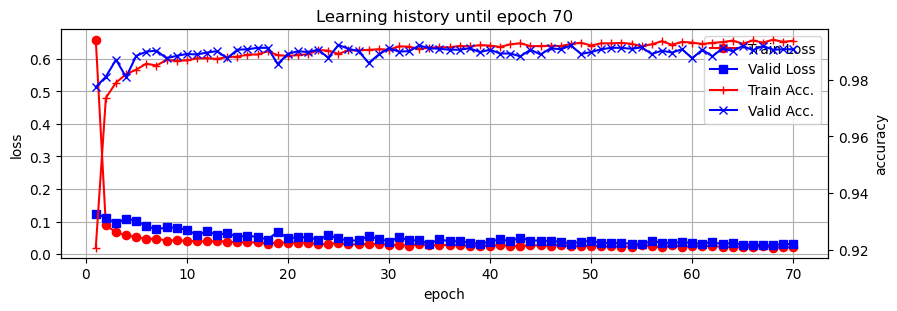

Epoch:  70 | T_Loss 0.021 | T_acc 0.994 | V_Loss 0.031 | V_acc. 0.991 | 🕒 8.297
Epoch:  69 | T_Loss 0.022 | T_acc 0.993 | V_Loss 0.031 | V_acc. 0.991 | 🕒 8.199
Epoch:  68 | T_Loss  0.02 | T_acc 0.994 | V_Loss 0.027 | V_acc.  0.99 | 🕒 8.209
Epoch:  67 | T_Loss 0.024 | T_acc 0.993 | V_Loss 0.027 | V_acc. 0.992 | 🕒 8.163
Epoch:  66 | T_Loss 0.021 | T_acc 0.994 | V_Loss 0.029 | V_acc.  0.99 | 🕒 8.178
Epoch:  65 | T_Loss 0.023 | T_acc 0.993 | V_Loss 0.029 | V_acc. 0.992 | 🕒   8.3
Epoch:  64 | T_Loss 0.022 | T_acc 0.994 | V_Loss 0.035 | V_acc.  0.99 | 🕒 8.302
Epoch:  63 | T_Loss 0.023 | T_acc 0.993 | V_Loss  0.03 | V_acc. 0.991 | 🕒   8.4
Epoch:  62 | T_Loss 0.024 | T_acc 0.993 | V_Loss 0.037 | V_acc. 0.988 | 🕒 8.341
Epoch:  61 | T_Loss 0.026 | T_acc 0.993 | V_Loss 0.032 | V_acc.  0.99 | 🕒 8.244
Epoch:  60 | T_Loss 0.023 | T_acc 0.993 | V_Loss 0.034 | V_acc. 0.988 | 🕒 8.269
Epoch:  59 | T_Loss 0.022 | T_acc 0.993 | V_Loss 0.037 | V_acc. 0.991 | 🕒 8.327
Epoch:  58 | T_Loss 0.027 | T_acc 0.992 

In [82]:
# Training Initialization
init_model()
init_epoch()
init_log()
early_stopping = EarlyStopping(patience = 30)

best_test_acc, best_epoch = 0, 0
# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc, _, _ = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc, _, _ = epoch(valid_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()
    
    # early_stopping는 validation loss가 감소하였는지 확인
    early_stopping(vloss, net)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    with torch.no_grad():
        net.eval()
        _, test_acc, _, _ = epoch(test_loader, mode = 'test')
        
        # Test 점수가 가장 좋았던 모델을 저장한다
        if best_test_acc < test_acc:
            best_test_acc = test_acc
            best_epoch = epoch_cnt
            print('Epoch: {} / Test Acc: {} | 최고 점수가 갱신되었습니다. 모델 중간 저장을 시행합니다.'.format(best_epoch, round(best_test_acc, 5)))
            torch.save(net.state_dict(), './model.pth')

print('\n Training completed!')

# 정확도 검증
with torch.no_grad():
    test_loss, test_acc, _, _ = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))
    
print('저장된 Best Model: Epoch: {}/ Test Accuracy: {}'.format(best_epoch, round(best_test_acc, 3)))

In [ ]:
# 0.005 99.3

# 0.008 99.2 

#0.03 